# I. Importing the required libraries

In [1]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# II. Reading the data

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir("C:/Users/arjun/Documents/code/emotion_recognition_cnn-master/Data")
dir_list


['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
file_list=os.listdir("C:\EmmotionCorrelation-master\orthAmerican")
for f in file_list:
        nm = f.split('.')[0].split('-')
        path =  f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df


1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,03-01-01-01-01-01-02.wav,1,2,female,0,0,0,1
2,03-01-01-01-01-01-03.wav,1,3,male,0,0,0,1
3,03-01-01-01-01-01-04.wav,1,4,female,0,0,0,1
4,03-01-01-01-01-01-05.wav,1,5,male,0,0,0,1
...,...,...,...,...,...,...,...,...
1435,03-01-08-02-02-02-20.wav,1,20,female,1,1,1,8
1436,03-01-08-02-02-02-21.wav,1,21,male,1,1,1,8
1437,03-01-08-02-02-02-22.wav,1,22,female,1,1,1,8
1438,03-01-08-02-02-02-23.wav,1,23,male,1,1,1,8


# III. Plotting the audio file's waveform and its spectrogram

In [5]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load("C:/EmmotionCorrelation-master/newdata"+"/"+data_df.path[1439])
sample_rate, samples

03-01-06-02-02-01-14.wav


(22050,
 array([0.        , 0.        , 0.        , ..., 0.00125679, 0.00134766,
        0.        ], dtype=float32))

In [6]:
len(samples), sample_rate

(80195, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.2749547976806534

Text(0.5, 0, 'Seconds')

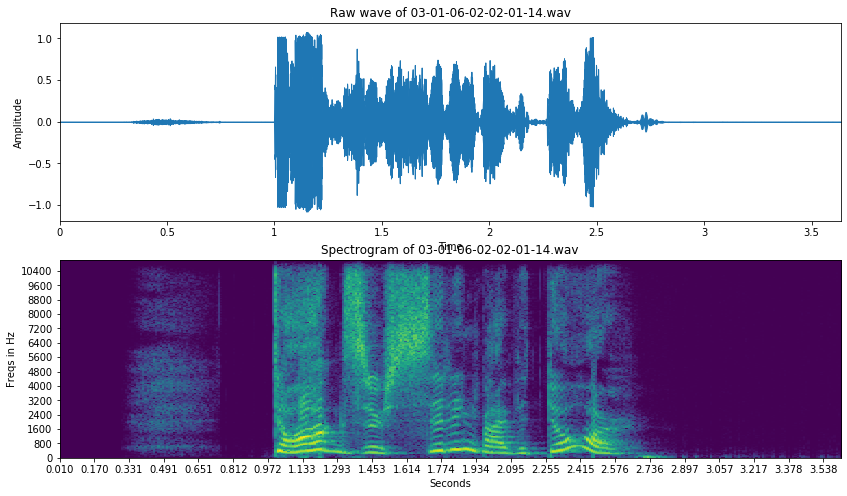

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00044006, -0.00099295, -0.00064619, ..., -0.0006677 ,
        -0.00054313, -0.00069186], dtype=float32),
 array([21504, 61440]))

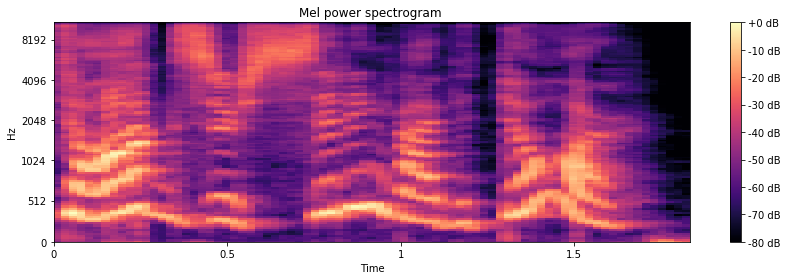

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

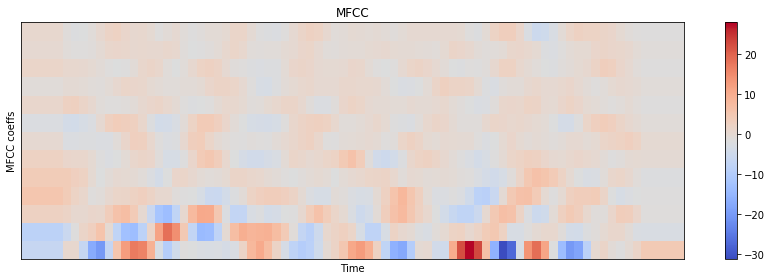

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [19]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [20]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [21]:
# Select the label set you want by commenting the unwanteds.

#data_df['label'] = label2_list
# data_df['label'] = label3_list
data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_none
1,03-01-01-01-01-01-02.wav,1,2,female,0,0,0,1,female_none
2,03-01-01-01-01-01-03.wav,1,3,male,0,0,0,1,male_none
3,03-01-01-01-01-01-04.wav,1,4,female,0,0,0,1,female_none
4,03-01-01-01-01-01-05.wav,1,5,male,0,0,0,1,male_none


In [22]:
print (data_df.label.value_counts().keys())

Index(['male_none', 'female_none', 'female_sad', 'male_sad', 'female_angry',
       'female_fearful', 'male_angry', 'female_happy', 'male_happy',
       'male_fearful', 'male_calm', 'female_calm'],
      dtype='object')


In [23]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

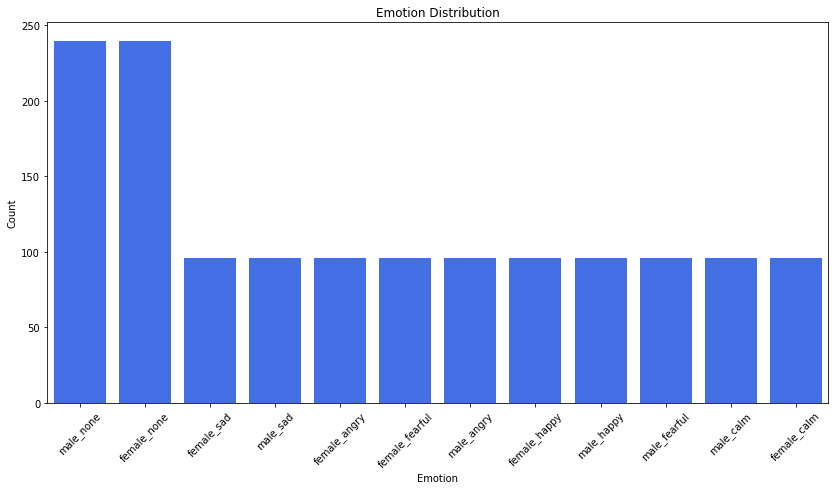

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [25]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
#data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [26]:
# Male Data Set

## Uncomment all below to use Male set 

#data2_df = data_df.copy()
#data2_df = data2_df[data2_df.label != "male_none"]
#data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
#data2_df = data2_df[data2_df.label != "female_neutral"]
#data2_df = data2_df[data2_df.label != "female_happy"]
#data2_df = data2_df[data2_df.label != "female_angry"]
#data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
#data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

#tmp1 = data2_df[data2_df.actor == 21]
#tmp2 = data2_df[data2_df.actor == 22]
#tmp3 = data2_df[data2_df.actor == 23]
#tmp4 = data2_df[data2_df.actor == 24]
#data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 21]
#data2_df = data2_df[data2_df.actor != 22]
#data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
#print (len(data2_df))
#data2_df.head()

In [27]:
print (len(data2_df))
data2_df.head()

768


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_calm
1,03-01-02-01-01-01-02.wav,1,2,female,0,0,0,2,female_calm
2,03-01-02-01-01-01-03.wav,1,3,male,0,0,0,2,male_calm
3,03-01-02-01-01-01-04.wav,1,4,female,0,0,0,2,female_calm
4,03-01-02-01-01-01-05.wav,1,5,male,0,0,0,2,male_calm


# VI. Getting the features of audio files using librosa

In [28]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/newdata"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [00:32<00:00, 23.57it/s]


In [29]:
data.head()

,feature
0,"[-52.20364104863782, -52.20364104863782, -52.2..."
1,"[-44.31779917308598, -40.749766438766976, -36...."
2,"[-48.86444315684633, -48.86444315684633, -48.8..."
3,"[-50.15276990426043, -50.11344235247516, -49.1..."
4,"[-40.8876867921146, -42.43716133679899, -40.12..."


In [30]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [31]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-52.203641,-52.203641,-52.203641,-52.203641,-52.203641,-49.415916,-49.031199,-49.049982,-49.473414,-45.630222,...,-42.972983,-44.009779,-45.415081,-50.339184,-52.094005,-51.457463,-50.124888,-49.307048,-51.445013,-51.835946
1,-44.317799,-40.749766,-36.612753,-36.313015,-36.645328,-37.790633,-42.079099,-42.025958,-39.703147,-42.224764,...,-35.945203,-38.137968,-38.786412,-39.432830,-39.330057,-39.054127,-40.393755,-42.245813,-41.664855,-41.451643
2,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.786014,-43.468487,-40.284814,...,-28.029537,-30.141197,-31.327168,-32.512907,-33.923872,-33.309895,-33.579391,-34.300365,-35.186097,-34.582175
3,-50.152770,-50.113442,-49.191551,-49.183656,-48.151851,-39.463568,-36.323028,-38.154407,-43.400301,-48.963471,...,-32.103986,-39.392711,-41.598435,-41.428317,-41.134491,-41.775984,-41.664375,-41.883484,-41.458253,-40.322132
4,-40.887687,-42.437161,-40.122610,-36.594175,-36.672820,-40.399057,-39.871406,-39.283370,-37.651242,-36.306846,...,-24.704676,-30.239586,-33.643850,-34.823871,-35.857598,-37.578255,-37.611185,-40.764813,-43.639797,-42.935033


In [32]:
newdf = pd.concat([df3,labels], axis=1)

In [33]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

768

In [34]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-52.203641,-52.203641,-52.203641,-52.203641,-52.203641,-49.415916,-49.031199,-49.049982,-49.473414,-45.630222,...,-44.009779,-45.415081,-50.339184,-52.094005,-51.457463,-50.124888,-49.307048,-51.445013,-51.835946,male_calm
1,-44.317799,-40.749766,-36.612753,-36.313015,-36.645328,-37.790633,-42.079099,-42.025958,-39.703147,-42.224764,...,-38.137968,-38.786412,-39.432830,-39.330057,-39.054127,-40.393755,-42.245813,-41.664855,-41.451643,female_calm
2,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.786014,-43.468487,-40.284814,...,-30.141197,-31.327168,-32.512907,-33.923872,-33.309895,-33.579391,-34.300365,-35.186097,-34.582175,male_calm
3,-50.152770,-50.113442,-49.191551,-49.183656,-48.151851,-39.463568,-36.323028,-38.154407,-43.400301,-48.963471,...,-39.392711,-41.598435,-41.428317,-41.134491,-41.775984,-41.664375,-41.883484,-41.458253,-40.322132,female_calm
4,-40.887687,-42.437161,-40.122610,-36.594175,-36.672820,-40.399057,-39.871406,-39.283370,-37.651242,-36.306846,...,-30.239586,-33.643850,-34.823871,-35.857598,-37.578255,-37.611185,-40.764813,-43.639797,-42.935033,male_calm
5,-53.883639,-53.883639,-53.883639,-53.883639,-53.883639,-53.883639,-53.883639,-53.883639,-53.741659,-47.298632,...,-35.626906,-37.297254,-37.836819,-37.063139,-36.859929,-36.344533,-35.916809,-33.688935,-33.345597,female_calm
6,-41.984679,-42.859017,-43.157315,-43.311649,-42.573284,-40.065834,-36.662874,-36.647791,-36.805243,-34.139246,...,-34.780339,-32.733652,-33.736336,-34.163241,-35.000150,-34.766702,-35.328661,-36.123086,NaN,male_calm
7,-34.486188,-32.173787,-31.861967,-32.596518,-31.653999,-33.155592,-34.195473,-32.587721,-32.521866,-32.288218,...,-31.442419,-31.920655,-31.677163,-32.152256,-32.841541,-36.617487,-34.482161,-32.350699,-32.672143,female_calm
8,-54.855920,-55.638581,-55.564178,-45.931595,-44.069889,-49.158704,-55.535129,-49.580008,-42.603927,-39.634977,...,-40.617557,-37.451204,-37.215800,-39.885389,-40.272624,-39.914893,NaN,NaN,NaN,male_calm
9,-29.138510,-26.598387,-25.930812,-26.501338,-28.447869,-28.826748,-27.468009,-18.617559,-13.833859,-13.823449,...,-25.514243,-27.025210,-28.465201,-28.543241,-28.540755,-28.775683,-29.435217,-30.396271,-30.463880,female_calm


In [35]:
rnewdf.isnull().sum().sum()

464

In [36]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-52.203641,-52.203641,-52.203641,-52.203641,-52.203641,-49.415916,-49.031199,-49.049982,-49.473414,-45.630222,...,-44.009779,-45.415081,-50.339184,-52.094005,-51.457463,-50.124888,-49.307048,-51.445013,-51.835946,male_calm
1,-44.317799,-40.749766,-36.612753,-36.313015,-36.645328,-37.790633,-42.079099,-42.025958,-39.703147,-42.224764,...,-38.137968,-38.786412,-39.432830,-39.330057,-39.054127,-40.393755,-42.245813,-41.664855,-41.451643,female_calm
2,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.786014,-43.468487,-40.284814,...,-30.141197,-31.327168,-32.512907,-33.923872,-33.309895,-33.579391,-34.300365,-35.186097,-34.582175,male_calm
3,-50.152770,-50.113442,-49.191551,-49.183656,-48.151851,-39.463568,-36.323028,-38.154407,-43.400301,-48.963471,...,-39.392711,-41.598435,-41.428317,-41.134491,-41.775984,-41.664375,-41.883484,-41.458253,-40.322132,female_calm
4,-40.887687,-42.437161,-40.122610,-36.594175,-36.672820,-40.399057,-39.871406,-39.283370,-37.651242,-36.306846,...,-30.239586,-33.643850,-34.823871,-35.857598,-37.578255,-37.611185,-40.764813,-43.639797,-42.935033,male_calm


# VII. Data Augmentation

In [37]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




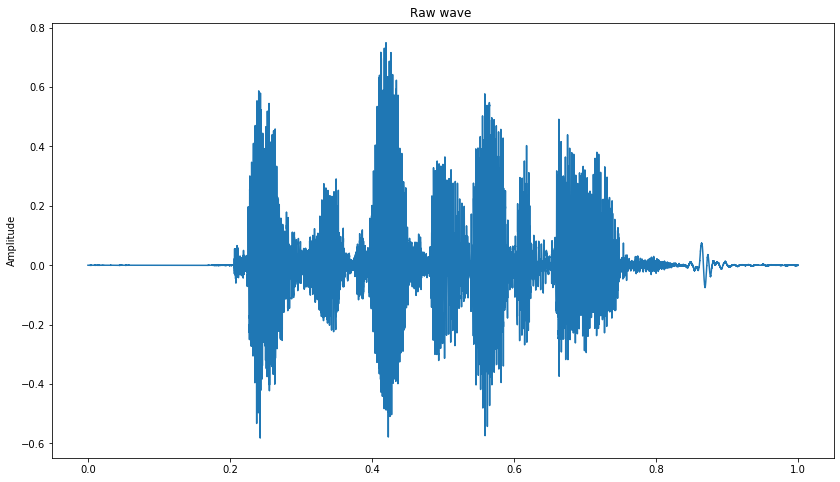

In [38]:
X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/newdata"+"/"+data2_df.path[216], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

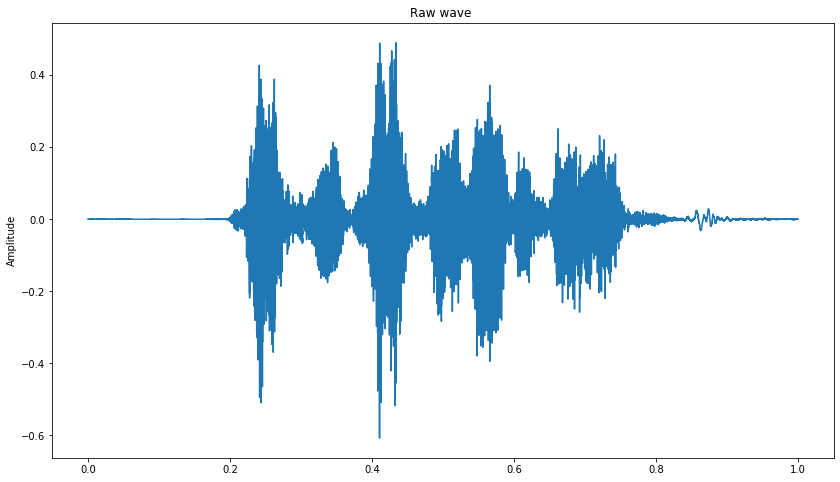

In [39]:
x = pitch(X,11025)
plot_time_series(x)
ipd.Audio(x, rate=11025)  

In [40]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/newdata"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [00:33<00:00, 22.71it/s]


In [41]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/newdata"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [01:11<00:00, 10.70it/s]


In [42]:
len(syn_data1), len(syn_data2) 

(768, 768)

In [43]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [44]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

768

In [45]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-37.958280,-38.527216,-38.680390,-38.503222,-38.790621,-38.790704,-38.845473,-38.815164,-37.891597,-35.980367,...,-37.349415,-38.590024,-37.679066,-38.755163,-37.726658,-37.064893,-38.585545,-39.285533,-37.900119,male_calm
1,-37.333844,-35.253096,-32.784049,-32.461118,-32.729743,-34.269522,-35.099640,-34.599902,-34.345304,-35.157558,...,-32.979211,-33.774032,-34.584798,-34.869646,-34.328384,-34.466962,-35.642419,-36.190741,-35.184985,female_calm
2,-35.611671,-34.030376,-32.172484,-31.461298,-30.981434,-30.218012,-31.923391,-33.869857,-31.623281,-30.378898,...,-25.922452,-26.929141,-27.347452,-28.162821,-27.659551,-29.350545,-29.715070,-28.871674,-28.383545,male_calm
3,-35.608897,-35.785958,-35.060364,-34.512070,-33.753174,-32.620445,-31.872758,-32.263999,-34.332231,-34.819833,...,-33.196830,-34.135513,-32.757980,-33.636047,-34.927514,-35.191418,-34.358792,-33.506367,-34.057402,female_calm
4,-35.933357,-36.340909,-34.111647,-32.930620,-33.327560,-35.503422,-35.083141,-34.743771,-34.097818,-32.855591,...,-28.891576,-31.377349,-32.482626,-33.240487,-34.283787,-33.929008,-35.813029,-37.336027,-35.771536,male_calm


In [46]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

768

In [47]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-56.192801,-56.192801,-56.192801,-55.765334,-55.454333,-53.144984,-51.505379,-51.248632,-47.476810,-40.977108,...,-48.099710,-49.065387,-51.749293,-54.934466,-54.596761,-53.766384,-53.502049,-55.007606,-55.969298,male_calm
1,-47.483316,-42.792892,-39.179309,-39.028831,-38.966684,-40.867028,-42.259879,-43.902506,-41.724560,-38.285101,...,-40.867686,-41.321327,-41.735970,-42.746468,-42.974368,-43.696813,-45.839526,-45.851817,-46.708789,female_calm
2,-48.959768,-48.959768,-48.959768,-48.959768,-48.959768,-48.959768,-48.971108,-48.959768,-43.656994,-36.897679,...,-33.235292,-35.184392,-37.229530,-37.684765,-36.637449,-35.770559,-36.357853,-38.136687,-40.047816,male_calm
3,-52.357687,-52.357687,-51.114795,-50.728480,-47.014623,-40.149768,-38.366919,-40.561044,-46.814870,-46.628557,...,-37.500359,-42.875498,-43.993811,-44.559774,-44.372867,-44.944959,-44.955892,-44.324836,-45.731140,female_calm
4,-40.616782,-41.922537,-39.779883,-37.525464,-38.968378,-40.741154,-40.698761,-41.034340,-38.582366,-35.219949,...,-31.581711,-34.978839,-37.957197,-39.447610,-39.785914,-40.483077,-42.752899,-44.686342,-46.433947,male_calm


In [48]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-52.203641,-52.203641,-52.203641,-52.203641,-52.203641,-49.415916,-49.031199,-49.049982,-49.473414,-45.630222,...,-44.009779,-45.415081,-50.339184,-52.094005,-51.457463,-50.124888,-49.307048,-51.445013,-51.835946,male_calm
1,-44.317799,-40.749766,-36.612753,-36.313015,-36.645328,-37.790633,-42.079099,-42.025958,-39.703147,-42.224764,...,-38.137968,-38.786412,-39.432830,-39.330057,-39.054127,-40.393755,-42.245813,-41.664855,-41.451643,female_calm
2,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.864443,-48.786014,-43.468487,-40.284814,...,-30.141197,-31.327168,-32.512907,-33.923872,-33.309895,-33.579391,-34.300365,-35.186097,-34.582175,male_calm
3,-50.152770,-50.113442,-49.191551,-49.183656,-48.151851,-39.463568,-36.323028,-38.154407,-43.400301,-48.963471,...,-39.392711,-41.598435,-41.428317,-41.134491,-41.775984,-41.664375,-41.883484,-41.458253,-40.322132,female_calm
4,-40.887687,-42.437161,-40.122610,-36.594175,-36.672820,-40.399057,-39.871406,-39.283370,-37.651242,-36.306846,...,-30.239586,-33.643850,-34.823871,-35.857598,-37.578255,-37.611185,-40.764813,-43.639797,-42.935033,male_calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,-39.388502,-39.552921,-39.562138,-38.859929,-37.122667,-34.284882,-29.934985,-26.245111,-24.880560,-21.680566,...,-39.256000,-39.119369,-39.143459,-39.333596,-39.326301,-39.155346,-39.181733,-39.386160,-39.388502,female_angry
2300,-36.832649,-36.832649,-36.786327,-35.371332,-32.949688,-31.036567,-30.557943,-30.316633,-28.083387,-13.926497,...,2.597296,-2.684764,-7.802729,-12.145490,-15.388773,-19.364922,-25.349026,-29.671813,-33.406058,male_angry
2301,-34.126561,-34.157180,-32.779704,-30.975029,-31.777951,-33.979742,-35.448082,-37.101538,-39.005008,-32.289107,...,-13.670082,-20.393324,-27.726065,-31.204585,-34.664955,-36.805310,-37.182386,-37.989346,-38.572379,female_angry
2302,-37.758493,-37.758493,-37.758493,-37.758493,-37.758493,-37.758493,-37.758493,-38.516877,-35.170661,-19.764136,...,-36.692933,-34.895563,-33.241950,-33.538068,-34.949041,0.000000,0.000000,0.000000,0.000000,male_angry


In [49]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [50]:
y_train.value_counts()

female_angry    231
male_angry      231
male_happy      231
female_sad      230
male_sad        230
female_happy    230
male_calm       230
female_calm     230
Name: label, dtype: int64

In [51]:
y_test.value_counts()

female_sad      58
male_sad        58
female_happy    58
male_calm       58
female_calm     58
male_angry      57
male_happy      57
female_angry    57
Name: label, dtype: int64

In [52]:
X_train.isna().sum().sum()

0

In [53]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [54]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [55]:
X_train.shape

(1843, 65)

# VIII. Changing dimension for CNN model

In [56]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [57]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [58]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [59]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [60]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 65, 256)           2304      
_________________________________________________________________
activation_1 (Activation)    (None, 65, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 256)           524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 256)           1024      
_________________________________________________________________
activation_2 (Activation)    (None, 65, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 65, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)           

In [61]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [62]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Train on 1843 samples, validate on 461 samples
Epoch 1/700
1843/1843 [==============================] - 11s 6ms/step - loss: 2.0824 - accuracy: 0.1243 - fscore: 0.0000e+00 - val_loss: 2.0794 - val_accuracy: 0.1215 - val_fscore: 0.0000e+00
Epoch 2/700
1843/1843 [==============================] - 9s 5ms/step - loss: 2.0746 - accuracy: 0.1340 - fscore: 0.0000e+00 - val_loss: 2.0755 - val_accuracy: 0.1215 - val_fscore: 0.0000e+00
Epoch 3/700
1843/1843 [==============================] - 9s 5ms/step - loss: 2.0696 - accuracy: 0.1460 - fscore: 0.0000e+00 - val_loss: 2.0697 - val_accuracy: 0.1475 - val_fscore: 0.0000e+00
Epoch 4/700
1843/1843 [==============================] - 10s 5ms/step - loss: 2.0638 - accuracy: 0.1329 - fscore: 0.0000e+00 - val_loss: 2.0643 - val_accuracy: 0.1909 - val_fscore: 0.0000e+00
Epoch 5/700
1843/1843 [==============================] - 10s 6ms/step - loss: 2.0592 - accuracy: 0.1487 - fscore: 0.0000e+00 - val_loss: 2.0601 - val_accuracy: 0.1996 - val_fscore: 0.000

1843/1843 [==============================] - 9s 5ms/step - loss: 1.7071 - accuracy: 0.3700 - fscore: 0.0081 - val_loss: 1.7656 - val_accuracy: 0.3818 - val_fscore: 0.0000e+00
Epoch 86/700
1843/1843 [==============================] - 10s 5ms/step - loss: 1.6947 - accuracy: 0.3706 - fscore: 0.0112 - val_loss: 1.7618 - val_accuracy: 0.3839 - val_fscore: 0.0000e+00
Epoch 87/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.6976 - accuracy: 0.3690 - fscore: 0.0090 - val_loss: 1.7585 - val_accuracy: 0.3818 - val_fscore: 0.0000e+00
Epoch 88/700
1843/1843 [==============================] - 10s 6ms/step - loss: 1.6850 - accuracy: 0.3728 - fscore: 0.0101 - val_loss: 1.7564 - val_accuracy: 0.3883 - val_fscore: 0.0000e+00
Epoch 89/700
1843/1843 [==============================] - 10s 5ms/step - loss: 1.6922 - accuracy: 0.3700 - fscore: 0.0193 - val_loss: 1.7509 - val_accuracy: 0.3774 - val_fscore: 0.0000e+00
Epoch 90/700
1843/1843 [==============================] - 9s 5ms/step 

1843/1843 [==============================] - 9s 5ms/step - loss: 1.3130 - accuracy: 0.5035 - fscore: 0.2341 - val_loss: 1.4083 - val_accuracy: 0.5141 - val_fscore: 0.0744
Epoch 173/700
1843/1843 [==============================] - 10s 5ms/step - loss: 1.3144 - accuracy: 0.4948 - fscore: 0.2218 - val_loss: 1.4056 - val_accuracy: 0.5119 - val_fscore: 0.0821
Epoch 174/700
1843/1843 [==============================] - 10s 5ms/step - loss: 1.3153 - accuracy: 0.4840 - fscore: 0.2295 - val_loss: 1.3974 - val_accuracy: 0.5163 - val_fscore: 0.0834
Epoch 175/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.3149 - accuracy: 0.4927 - fscore: 0.2234 - val_loss: 1.4032 - val_accuracy: 0.5184 - val_fscore: 0.1010
Epoch 176/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.3257 - accuracy: 0.4889 - fscore: 0.2354 - val_loss: 1.3915 - val_accuracy: 0.5206 - val_fscore: 0.0983
Epoch 177/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.2917 -

1843/1843 [==============================] - 9s 5ms/step - loss: 1.0521 - accuracy: 0.5920 - fscore: 0.4025 - val_loss: 1.1864 - val_accuracy: 0.6052 - val_fscore: 0.2755
Epoch 261/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.0454 - accuracy: 0.5827 - fscore: 0.4190 - val_loss: 1.2125 - val_accuracy: 0.5727 - val_fscore: 0.2464
Epoch 262/700
1843/1843 [==============================] - 8s 4ms/step - loss: 1.0368 - accuracy: 0.6088 - fscore: 0.4160 - val_loss: 1.2038 - val_accuracy: 0.5683 - val_fscore: 0.3163
Epoch 263/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.0288 - accuracy: 0.6050 - fscore: 0.4288 - val_loss: 1.1933 - val_accuracy: 0.5922 - val_fscore: 0.2652
Epoch 264/700
1843/1843 [==============================] - 10s 5ms/step - loss: 1.0395 - accuracy: 0.5996 - fscore: 0.4063 - val_loss: 1.2060 - val_accuracy: 0.5683 - val_fscore: 0.2863
Epoch 265/700
1843/1843 [==============================] - 9s 5ms/step - loss: 1.0418 - 

1843/1843 [==============================] - 10s 5ms/step - loss: 0.8314 - accuracy: 0.6880 - fscore: 0.5871 - val_loss: 1.0060 - val_accuracy: 0.6399 - val_fscore: 0.4609
Epoch 349/700
1843/1843 [==============================] - 8s 4ms/step - loss: 0.8193 - accuracy: 0.6945 - fscore: 0.5867 - val_loss: 1.0096 - val_accuracy: 0.6312 - val_fscore: 0.4410
Epoch 350/700
1843/1843 [==============================] - 10s 5ms/step - loss: 0.8305 - accuracy: 0.6842 - fscore: 0.5928 - val_loss: 1.0640 - val_accuracy: 0.6117 - val_fscore: 0.4145
Epoch 351/700
1843/1843 [==============================] - 10s 5ms/step - loss: 0.8199 - accuracy: 0.6972 - fscore: 0.5952 - val_loss: 0.9943 - val_accuracy: 0.6551 - val_fscore: 0.4694
Epoch 352/700
1843/1843 [==============================] - 11s 6ms/step - loss: 0.8170 - accuracy: 0.7070 - fscore: 0.6008 - val_loss: 1.0061 - val_accuracy: 0.6486 - val_fscore: 0.4476
Epoch 353/700
1843/1843 [==============================] - 10s 5ms/step - loss: 0.820

1843/1843 [==============================] - 9s 5ms/step - loss: 0.6331 - accuracy: 0.7819 - fscore: 0.7287 - val_loss: 0.8732 - val_accuracy: 0.6855 - val_fscore: 0.5838
Epoch 437/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.6408 - accuracy: 0.7721 - fscore: 0.7252 - val_loss: 1.2020 - val_accuracy: 0.5380 - val_fscore: 0.4611
Epoch 438/700
1843/1843 [==============================] - 8s 5ms/step - loss: 0.6190 - accuracy: 0.7933 - fscore: 0.7383 - val_loss: 0.8484 - val_accuracy: 0.7137 - val_fscore: 0.5923
Epoch 439/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.6347 - accuracy: 0.7754 - fscore: 0.7378 - val_loss: 1.0013 - val_accuracy: 0.6529 - val_fscore: 0.5838
Epoch 440/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.6292 - accuracy: 0.7927 - fscore: 0.7464 - val_loss: 2.0224 - val_accuracy: 0.3688 - val_fscore: 0.3874
Epoch 441/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.6329 - a

1843/1843 [==============================] - 9s 5ms/step - loss: 0.4678 - accuracy: 0.8388 - fscore: 0.8241 - val_loss: 1.7023 - val_accuracy: 0.4338 - val_fscore: 0.4498
Epoch 525/700
1843/1843 [==============================] - 8s 4ms/step - loss: 0.4782 - accuracy: 0.8416 - fscore: 0.8225 - val_loss: 0.8738 - val_accuracy: 0.6855 - val_fscore: 0.6315
Epoch 526/700
1843/1843 [==============================] - 10s 6ms/step - loss: 0.4616 - accuracy: 0.8557 - fscore: 0.8316 - val_loss: 0.7430 - val_accuracy: 0.7310 - val_fscore: 0.6779
Epoch 527/700
1843/1843 [==============================] - 8s 5ms/step - loss: 0.4646 - accuracy: 0.8464 - fscore: 0.8328 - val_loss: 1.0127 - val_accuracy: 0.6269 - val_fscore: 0.5790
Epoch 528/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.4709 - accuracy: 0.8508 - fscore: 0.8268 - val_loss: 0.8342 - val_accuracy: 0.7028 - val_fscore: 0.6604
Epoch 529/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.4770 - 

1843/1843 [==============================] - 9s 5ms/step - loss: 0.3342 - accuracy: 0.9072 - fscore: 0.8969 - val_loss: 0.6494 - val_accuracy: 0.7701 - val_fscore: 0.7550
Epoch 613/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.3395 - accuracy: 0.9002 - fscore: 0.8906 - val_loss: 0.6593 - val_accuracy: 0.7527 - val_fscore: 0.7077
Epoch 614/700
1843/1843 [==============================] - 9s 5ms/step - loss: 0.3240 - accuracy: 0.9099 - fscore: 0.8976 - val_loss: 0.7069 - val_accuracy: 0.7636 - val_fscore: 0.7248
Epoch 615/700
1843/1843 [==============================] - 10s 5ms/step - loss: 0.3208 - accuracy: 0.9056 - fscore: 0.8967 - val_loss: 0.7450 - val_accuracy: 0.7267 - val_fscore: 0.7197
Epoch 616/700
1843/1843 [==============================] - 10s 5ms/step - loss: 0.3473 - accuracy: 0.8974 - fscore: 0.8929 - val_loss: 0.6114 - val_accuracy: 0.7896 - val_fscore: 0.7428
Epoch 617/700
1843/1843 [==============================] - 8s 5ms/step - loss: 0.3402 -

1843/1843 [==============================] - 10s 5ms/step - loss: 0.2584 - accuracy: 0.9230 - fscore: 0.9189 - val_loss: 0.5242 - val_accuracy: 0.8395 - val_fscore: 0.8034


In [ ]:
# Plotting the Train Valid Loss Graph
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

## Saving the model

In [ ]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [1]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Using TensorFlow backend.
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py


Loaded model from disk


NameError: name 'opt' is not defined

# X. Predicting emotions on the test data

In [73]:
preds = loaded_model.predict(xtest_cnn, 
                         batch_size=16, 
                         verbose=1)

NameError: name 'xtest_cnn' is not defined

48/48 [==============================] - 0s 5ms/step


In [117]:
preds

array([[7.24437609e-02, 3.71873379e-01, 3.51563916e-02, 9.41767618e-02,
        1.72229037e-02, 4.47345944e-03, 2.04717112e-03, 4.02606159e-01],
       [1.77447096e-01, 6.18967175e-01, 2.54974756e-02, 6.97693750e-02,
        9.49908234e-03, 2.83353240e-03, 1.13171176e-03, 9.48546082e-02],
       [2.25406438e-02, 1.51631579e-01, 1.67568579e-01, 6.56187594e-01,
        1.09760018e-04, 1.33050241e-06, 3.39965554e-05, 1.92656880e-03],
       [1.10693658e-02, 2.98766028e-02, 3.46637778e-02, 8.84515345e-01,
        3.17523009e-05, 3.86503780e-05, 6.33408723e-04, 3.91711444e-02],
       [5.77989146e-02, 1.04677965e-04, 1.58742059e-03, 2.46517430e-03,
        6.29782025e-03, 1.53751737e-02, 8.46874237e-01, 6.94965646e-02],
       [1.99179724e-01, 3.31936739e-02, 2.56269146e-02, 6.18477948e-02,
        4.32316251e-02, 6.02902807e-02, 1.53091758e-01, 4.23538297e-01],
       [3.73536319e-01, 4.34062304e-03, 5.32871664e-01, 6.91665486e-02,
        2.33976590e-03, 1.83134798e-05, 7.12372130e-03, 1.

In [118]:
preds1=preds.argmax(axis=1)

In [119]:
preds1

array([7, 1, 3, 3, 6, 7, 2, 7, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 7, 1, 7, 4,
       3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 0, 7, 7, 3, 0, 0, 3, 3, 3, 3, 3, 1,
       1, 3, 3, 1], dtype=int64)

In [120]:
abc = preds1.astype(int).flatten()

In [121]:
predictions = (lb.inverse_transform((abc)))

In [122]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_sad
1,female_calm
2,female_sad
3,female_sad
4,male_happy
5,male_sad
6,female_happy
7,male_sad
8,female_sad
9,female_sad


In [123]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [124]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_angry
2,male_happy
3,male_happy
4,male_calm
5,male_calm
6,male_sad
7,male_sad
8,female_angry
9,female_angry


In [125]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [127]:
finaldf

,actualvalues,predictedvalues
0,male_angry,male_sad
1,male_angry,female_calm
2,male_happy,female_sad
3,male_happy,female_sad
4,male_calm,male_happy
5,male_calm,male_sad
6,male_sad,female_happy
7,male_sad,male_sad
8,female_angry,female_sad
9,female_angry,female_sad


In [128]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,6
female_calm,6
female_happy,6
female_sad,6
male_angry,6
male_calm,6
male_happy,6
male_sad,6


In [129]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,4
female_calm,12
female_happy,1
female_sad,22
male_angry,1
male_happy,1
male_sad,7


In [130]:
finaldf.to_csv('Predictions.csv', index=False)

In [131]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [132]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

16.666666666666664

In [133]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

10.157203907203908

In [134]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[0, 0, 0, 6, 0, 0, 0, 0],
       [0, 4, 0, 2, 0, 0, 0, 0],
       [0, 1, 0, 5, 0, 0, 0, 0],
       [0, 3, 0, 3, 0, 0, 0, 0],
       [1, 3, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 1, 0, 1, 2],
       [0, 1, 0, 3, 0, 0, 0, 2],
       [1, 0, 1, 3, 0, 0, 0, 1]], dtype=int64)

In [135]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

ValueError: Shape of passed values is (8, 8), indices imply (2, 2)